In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from torch.utils.data import  DataLoader
import datetime

In [2]:
from utils.common_utils import fraud_classes_mapping

In [3]:
import torch
from torch import nn
from tqdm import tqdm
import os

In [4]:
columns1 = list(map(lambda x: x.lower().replace('_',' '),["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","target",'ne_ponytno']))
columns2 = list(map(lambda x: x.lower().replace('_',' '), """Duration
Service
Source bytes
Destination bytes
Count
Same srv rate
Serror rate
Srv serror rate
Dst host count
Dst host srv count
Dst host same src port rate
Dst host serror rate
Dst host srv serror rate
Flag
IDS detection
Malware detection
Ashula detection
Label
Source IP Address
Source Port Number
Destination IP Address
Destination Port Number
Start Time
Duration1""".split('\n')))

In [5]:
common = list(set(columns1) & set(columns2))
common

['serror rate',
 'dst host count',
 'same srv rate',
 'duration',
 'dst host srv count',
 'dst host serror rate',
 'dst host same src port rate',
 'count',
 'dst host srv serror rate',
 'service',
 'flag',
 'srv serror rate']

In [6]:
train = pd.read_csv('../data/KDD/KDDTrain+.txt', names=columns1)
test = pd.read_csv('../data/KDD/KDDTest+.txt', names=columns1)

In [7]:
y_tr = fraud_classes_mapping(train.target)
y_test = fraud_classes_mapping(test.target)
df = pd.concat([train,test],ignore_index=True)
y_df = fraud_classes_mapping(df.target)

In [8]:
train = train[common]
test = test[common]
df = df[common]

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [10]:
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = LabelEncoder().fit_transform(df[i])

In [11]:
le_y = LabelEncoder()
le_y.fit(y_df)

LabelEncoder()

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df[:len(train)], le_y.transform(y_tr), test_size=0.2, random_state=42, stratify=le_y.transform(y_tr))

In [13]:
rfc = RandomForestClassifier(n_jobs=-1)

In [14]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

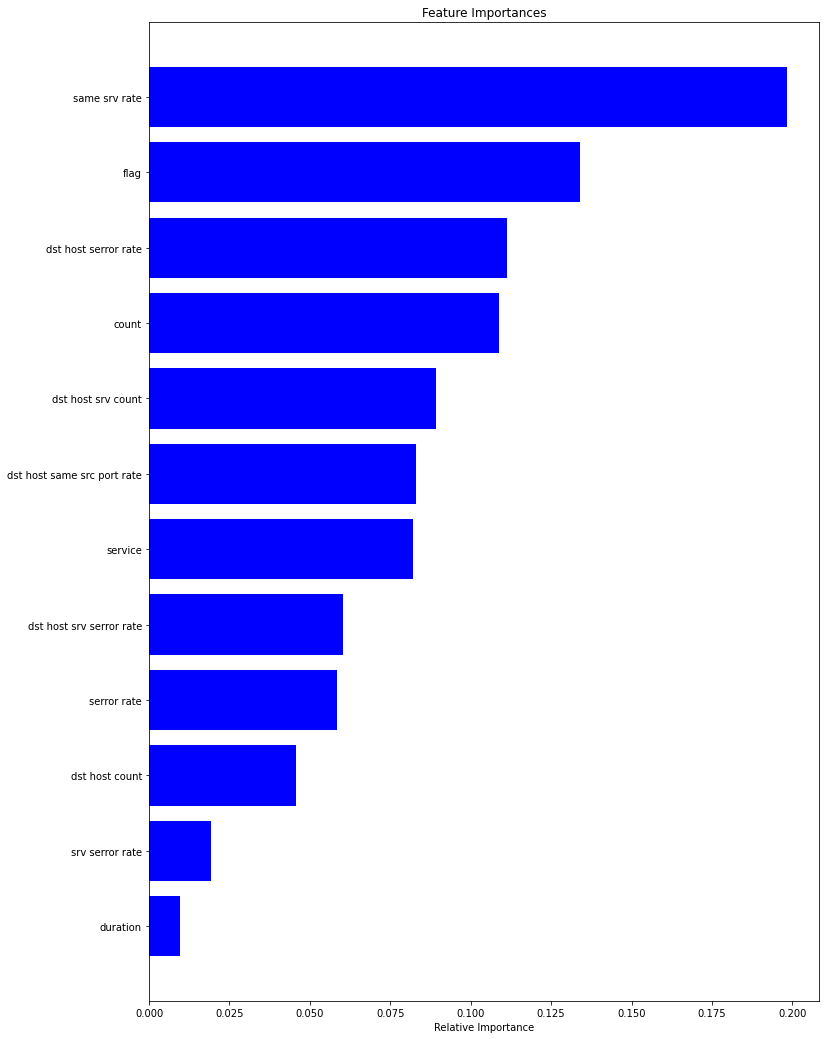

In [15]:
features = df.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,18))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [16]:
print(f'Точность на валидационной выборке: {accuracy_score(rfc.predict(X_val),y_val):.5f}')
print(f"Точность на тестовой выборке: {accuracy_score(rfc.predict(df[len(train):]), le_y.transform(y_test)):.4f}")
start = datetime.datetime.now()
rfc.predict(df[len(train):])
end = datetime.datetime.now()
print(f'Время выполнения расчета для {len(y_test)} строк логов (тестовая выборка):\n{end-start}')

Точность на валидационной выборке: 0.99091
Точность на тестовой выборке: 0.7454
Время выполнения расчета для 22544 строк логов (тестовая выборка):
0:00:00.108265


In [17]:
%%timeit
rfc.predict(df[len(train):])

108 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Kyoto

In [18]:
path = '../data/Kyoto2016/'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))
files[:4]

['../data/Kyoto2016/2015/01/20150122.txt',
 '../data/Kyoto2016/2015/01/20150131.txt',
 '../data/Kyoto2016/2015/01/20150130.txt',
 '../data/Kyoto2016/2015/01/20150113.txt']

In [19]:
common = ['same srv rate',
 'service',
 'serror rate',
 'flag',
 'dst host same src port rate',
 'srv serror rate',
 'dst host srv serror rate',
 'dst host srv count',
 'count',
 'duration',
 'dst host serror rate',
 'dst host count']

In [21]:
len(files)

366

In [31]:
z = np.array([])
for i in tqdm(range(len(files))):
    data = pd.read_csv(files[i],sep='\t',names=columns2)[common]
    for i in train.columns:
        if train[i].dtype == 'object':
            train[i] = LabelEncoder().fit_transform(train[i])
    z= np.concatenate([z,rfc.predict(train)])    

  6%|▌         | 21/366 [00:25<06:03,  1.05s/it]/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
  7%|▋         | 24/366 [00:27<05:37,  1.01it/s]/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
  7%|▋         | 27/366 [00:31<05:47,  1.03s/it]/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
  9%|▊         | 32/366 [00:37<07:01,  1.26s/it]/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3

In [38]:
kk = pd.Series(le_y.inverse_transform(z.astype(int)))
kk

0           norm
1           norm
2            dos
3           norm
4           norm
            ... 
46106113     dos
46106114    norm
46106115    norm
46106116     dos
46106117    norm
Length: 46106118, dtype: object

In [40]:
import matplotlib

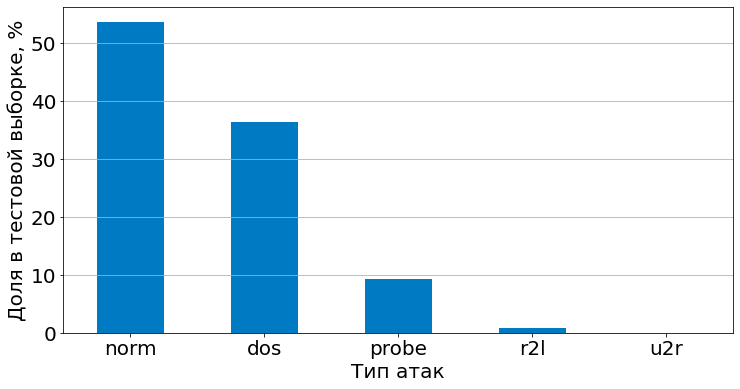

In [41]:
matplotlib.rcParams.update({'font.size': 20})
(kk.value_counts()/len(kk)*100).plot.bar(figsize=(12,6), color='#007AC3', rot=0)
plt.ylabel('Доля в тестовой выборке, %')
plt.xlabel('Тип атак')
plt.grid(axis='y')
plt.show()